In [1]:
from IPython.display import clear_output
!pip install -q albumentations
!pip install timm
clear_output()

# Add needed libraries

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import warnings
from PIL import Image

from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from typing import Optional,List
import timm

import albumentations as album
from albumentations.pytorch import ToTensorV2

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Data procressing and EDA

In [4]:
ham_df = pd.read_csv("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")
isic_df = pd.read_csv("/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv")

In [5]:
ham_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
isic_df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
isic_df.sum(axis = 0)

image    ISIC_0000000ISIC_0000001ISIC_0000002ISIC_00000...
MEL                                                 4522.0
NV                                                 12875.0
BCC                                                 3323.0
AK                                                   867.0
BKL                                                 2624.0
DF                                                   239.0
VASC                                                 253.0
SCC                                                  628.0
UNK                                                    0.0
dtype: object

In [8]:
len(ham_df), len(isic_df)

(10015, 25331)

In [9]:
label_map = {
    'nv': 'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign Keratosis',
    'bcc': 'Basal Cell Carcinoma',
    'akiec': 'Actinic Keratoses',
    'df': 'Dermatofibroma',
    'vasc': 'Vascular Lesions',
    'scc': 'Squamous Cell Carcinoma',
    'unk': 'Unknown'
}

In [10]:
label = list(label_map.values())[0:-1]
label

['Melanocytic Nevi',
 'Melanoma',
 'Benign Keratosis',
 'Basal Cell Carcinoma',
 'Actinic Keratoses',
 'Dermatofibroma',
 'Vascular Lesions',
 'Squamous Cell Carcinoma']

In [11]:
# HAM
ham_df['diagnosis'] = ham_df['dx'].map(label_map)
ham_df['dataset'] = 'HAM'
ham_df['image_path'] = ham_df['image_id'].apply(
    lambda x: f"/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/{x}.jpg"
    if os.path.exists(f"/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/{x}.jpg")
    else f"/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/{x}.jpg"
)

In [12]:
# ISIC
isic_df['image_id'] = isic_df['image']
isic_df['diagnosis'] = isic_df[['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']].idxmax(axis=1)
isic_df['diagnosis'] = isic_df['diagnosis'].str.lower().map(label_map)
isic_df['dataset'] = 'ISIC'
isic_df['image_path'] = isic_df['image_id'].apply(lambda x: f"/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/{x}.jpg")

In [13]:
ham_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,diagnosis,dataset,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign Keratosis,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign Keratosis,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign Keratosis,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign Keratosis,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign Keratosis,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,Actinic Keratoses,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,Actinic Keratoses,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,Actinic Keratoses,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,Actinic Keratoses,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...


In [14]:
isic_df

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,image_id,diagnosis,dataset,image_path
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0000000,Melanocytic Nevi,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0000001,Melanocytic Nevi,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0000002,Melanoma,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0000003,Melanocytic Nevi,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0000004,Melanoma,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0073247,Basal Cell Carcinoma,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,ISIC_0073248,Benign Keratosis,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0073249,Melanoma,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC_0073251,Melanocytic Nevi,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...


In [15]:
ham_df = ham_df[['image_id', 'diagnosis', 'dataset', 'image_path']]
ham_df

,image_id,diagnosis,dataset,image_path
0,ISIC_0027419,Benign Keratosis,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
1,ISIC_0025030,Benign Keratosis,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
2,ISIC_0026769,Benign Keratosis,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
3,ISIC_0025661,Benign Keratosis,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
4,ISIC_0031633,Benign Keratosis,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
...,...,...,...,...
10010,ISIC_0033084,Actinic Keratoses,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
10011,ISIC_0033550,Actinic Keratoses,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
10012,ISIC_0033536,Actinic Keratoses,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
10013,ISIC_0032854,Actinic Keratoses,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...


In [16]:
isic_df = isic_df[['image_id', 'diagnosis', 'dataset', 'image_path']]
isic_df

,image_id,diagnosis,dataset,image_path
0,ISIC_0000000,Melanocytic Nevi,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
1,ISIC_0000001,Melanocytic Nevi,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
2,ISIC_0000002,Melanoma,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
3,ISIC_0000003,Melanocytic Nevi,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
4,ISIC_0000004,Melanoma,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
...,...,...,...,...
25326,ISIC_0073247,Basal Cell Carcinoma,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
25327,ISIC_0073248,Benign Keratosis,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
25328,ISIC_0073249,Melanoma,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
25329,ISIC_0073251,Melanocytic Nevi,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...


In [17]:
combined_df = pd.concat([ham_df, isic_df], ignore_index=True)
combined_df

,image_id,diagnosis,dataset,image_path
0,ISIC_0027419,Benign Keratosis,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
1,ISIC_0025030,Benign Keratosis,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
2,ISIC_0026769,Benign Keratosis,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
3,ISIC_0025661,Benign Keratosis,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
4,ISIC_0031633,Benign Keratosis,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
...,...,...,...,...
35341,ISIC_0073247,Basal Cell Carcinoma,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
35342,ISIC_0073248,Benign Keratosis,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
35343,ISIC_0073249,Melanoma,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
35344,ISIC_0073251,Melanocytic Nevi,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...


In [18]:
combined_df["image_id"].duplicated().sum()

10015

In [19]:
combined_df.drop_duplicates(subset="image_id", inplace=True)
len(combined_df)

25331

In [20]:
combined_df.isna().sum()

image_id        0
diagnosis     737
dataset         0
image_path      0
dtype: int64

In [21]:
combined_df.dropna(subset=["diagnosis"], inplace=True)
len(combined_df)

24594

In [22]:
print("\nDiagnosis distribution:")
print(combined_df['diagnosis'].value_counts())


Diagnosis distribution:
diagnosis
Melanocytic Nevi           12875
Melanoma                    4522
Basal Cell Carcinoma        3323
Benign Keratosis            2624
Squamous Cell Carcinoma      431
Actinic Keratoses            327
Vascular Lesions             253
Dermatofibroma               239
Name: count, dtype: int64


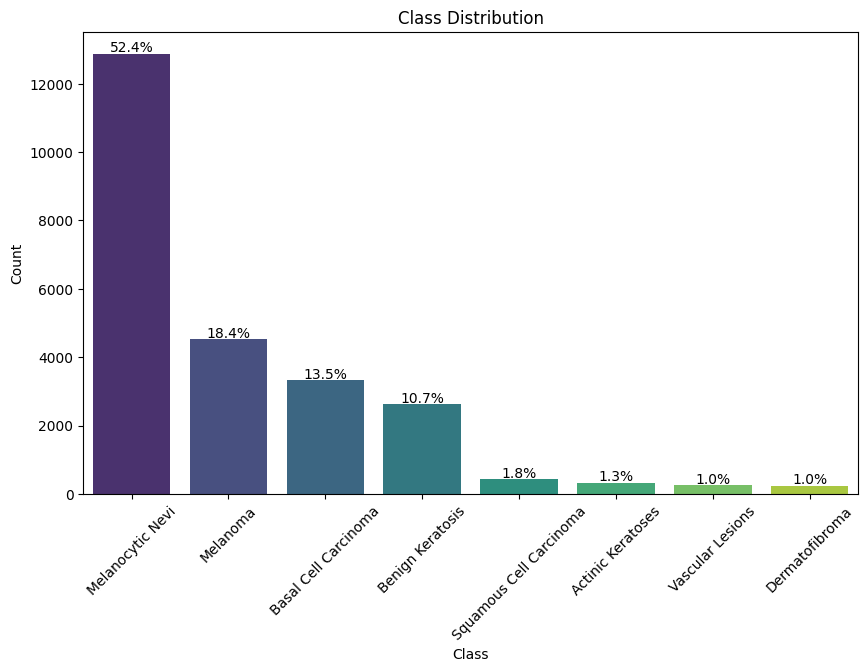

In [23]:
diag_counts = combined_df['diagnosis'].value_counts()
total = diag_counts.sum()

plt.figure(figsize=(10,6))
ax = sns.barplot(x=diag_counts.index, y=diag_counts.values, palette="viridis")

plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)

for p in ax.patches:
    count = p.get_height()
    percentage = f'{100*count/total:.1f}%'
    ax.text(p.get_x() + p.get_width()/2, 
            p.get_height() + 55,   
            percentage, 
            ha='center')

plt.show()

According to Class Distribution, we can easily see that this dataset is imbalanced. We need to make this data balanced by augmentation and downsampling classes with large distribution

In [24]:
def balance_classes_with_augmentation(df, label_columns, target_min=2500, target_max=3000, seed=42):
    random.seed(seed)
    np.random.seed(seed)

    balanced_dfs = []

    for label in label_columns:
        class_df = df[df["diagnosis"] == label]

        if len(class_df) > target_max:
            # Downsample
            sampled_df = class_df.sample(n=target_max, random_state=seed)
            sampled_df = sampled_df.copy()
            sampled_df["aug_flag"] = False
            balanced_dfs.append(sampled_df)

        elif len(class_df) < target_min:
            # Oversample with augmentation
            deficit = target_min - len(class_df)

            # Repeat samples with new "aug_flag"
            oversampled_df = class_df.sample(n=deficit, replace=True, random_state=seed)
            oversampled_df = oversampled_df.copy()
            oversampled_df["aug_flag"] = True  # Mark for augmentation

            class_df = class_df.copy()
            class_df["aug_flag"] = False

            balanced_dfs.append(pd.concat([class_df, oversampled_df]))

        else:
            class_df = class_df.copy()
            class_df["aug_flag"] = False
            balanced_dfs.append(class_df)
            
    final_df = pd.concat(balanced_dfs).reset_index(drop=True)
    return final_df

In [25]:
combined_augmented_df = balance_classes_with_augmentation(combined_df, label)
combined_augmented_df

,image_id,diagnosis,dataset,image_path,aug_flag
0,ISIC_0068849,Melanocytic Nevi,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,False
1,ISIC_0068458,Melanocytic Nevi,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,False
2,ISIC_0031325,Melanocytic Nevi,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,False
3,ISIC_0026241,Melanocytic Nevi,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,False
4,ISIC_0030217,Melanocytic Nevi,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,False
...,...,...,...,...,...
21619,ISIC_0056180,Squamous Cell Carcinoma,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,True
21620,ISIC_0073195,Squamous Cell Carcinoma,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,True
21621,ISIC_0059871,Squamous Cell Carcinoma,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,True
21622,ISIC_0057510,Squamous Cell Carcinoma,ISIC,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,True


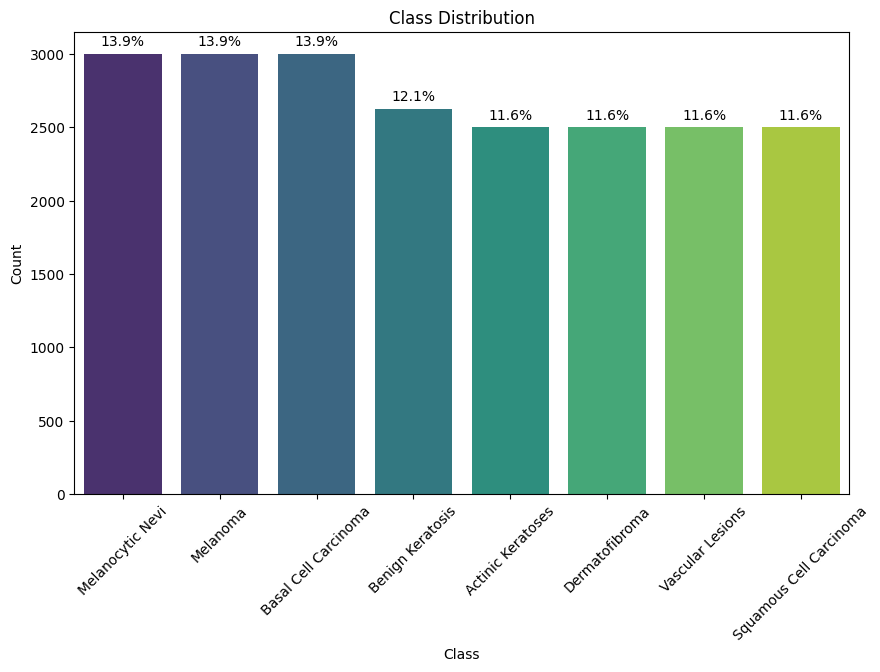

In [26]:
diag_counts = combined_augmented_df['diagnosis'].value_counts()
total = diag_counts.sum()

plt.figure(figsize=(10,6))
ax = sns.barplot(x=diag_counts.index, y=diag_counts.values, palette="viridis")

plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)

for p in ax.patches:
    count = p.get_height()
    percentage = f'{100*count/total:.1f}%'
    ax.text(p.get_x() + p.get_width()/2, 
            p.get_height() + 55,   
            percentage, 
            ha='center')

plt.show()

Test if image path is valid

In [27]:
combined_augmented_df["image_path"][0]

'/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0068849.jpg'

In [28]:
combined_augmented_df["image_path"][2]

'/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0031325.jpg'

In [29]:
def preprocess_image(img_path):
    if not os.path.exists(img_path):
        return None
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    return img

In [30]:
image_paths, labels, aug_flags = [], [], []
for _, row in tqdm(combined_augmented_df.iterrows(), total=len(combined_augmented_df)):
    img = preprocess_image(row['image_path'])
    if img is not None:
        image_paths.append(row['image_path'])
        labels.append(row['diagnosis'])
        aug_flags.append(row['aug_flag'])

image_paths = np.array(image_paths)
y = np.array(labels)
aug_flags = np.array(aug_flags)

100%|██████████| 21624/21624 [06:19<00:00, 56.98it/s]


In [31]:
len(image_paths), len(y), len(aug_flags)

(21624, 21624, 21624)

In [32]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

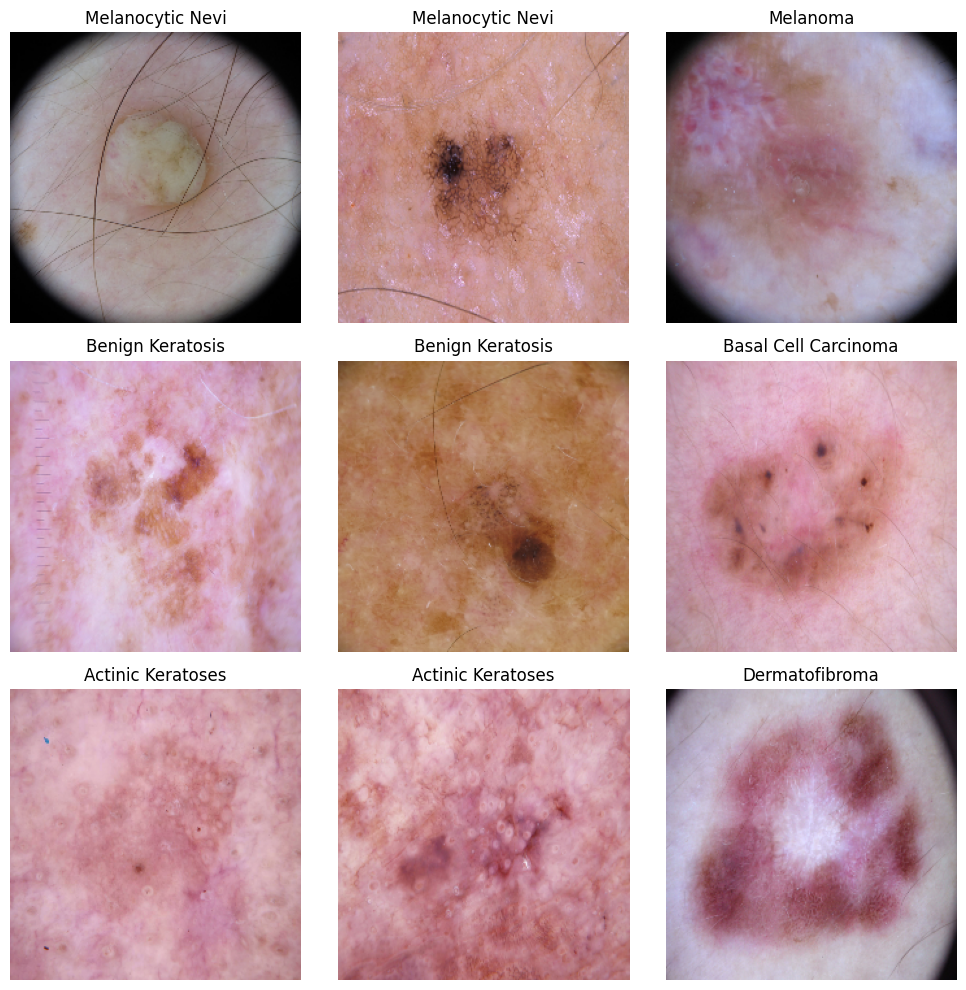

In [33]:
# === Preview Sample Images === #
def plot_samples(images_paths, y, label_encoder, n=9):
    plt.figure(figsize=(10, 10))
    for i in range(n):
        plt.subplot(3, 3, i + 1)
        plt.imshow(preprocess_image(images_paths[i*2000]))
        plt.title(label_encoder.inverse_transform([y[i*2000]])[0])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_samples(image_paths, y_encoded, le)

In [34]:
def get_base_transform(is_train : bool):
    if (is_train):
        return album.Compose([
            album.Resize(224, 224),
            album.HorizontalFlip(p=0.5),
            album.Rotate(limit=10, p=0.2),
            album.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
        
    else:
        return album.Compose([
            album.Resize(224, 224),
            album.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
def get_aug_transform():
    return album.Compose([
        album.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.0), ratio=(0.9, 1.1), p=1.0),
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.3),
        album.Rotate(limit=20, p=0.4),
        album.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.2),
        album.CoarseDropout(
            num_holes_range=(1, 2),
            hole_height_range=(1, 8),
            hole_width_range=(1, 8),
            p=0.2
        ),
        album.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    

In [35]:
class SkinLesionDataset(Dataset):
    def __init__(self, image_paths, targets, aug_flags, is_training: bool = True):
        self.image_paths = image_paths
        self.targets = targets
        self.aug_flags = aug_flags
        self.is_training = is_training
        self.base_transform = get_base_transform(is_training)
        self.aug_transform = get_aug_transform()
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
        try:
            if self.is_training and self.aug_flags[idx]:
                augmented = self.aug_transform(image=img)
            else:
                augmented = self.base_transform(image=img)
    
            img = augmented["image"]
            label = self.targets[idx]
            return img, label
        except Exception as e:
            warnings.warn(f"Error loading {img_path}: {e}")
            return None

In [36]:
class_counts = np.bincount(y_encoded)
class_weights = 1. / class_counts
sample_weights = class_weights[y_encoded]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

In [37]:
class_weights

array([0.0004    , 0.00033333, 0.0003811 , 0.0004    , 0.00033333,
       0.00033333, 0.0004    , 0.0004    ])

In [38]:
len(sample_weights)

21624

In [39]:
X_train, X_val, y_train, y_val, flag_train, flag_val = train_test_split(
    image_paths, y_encoded, aug_flags,
    test_size=0.2,        
    random_state=42,
    stratify=y_encoded            
)

In [40]:
X_train[0], y_train[0], flag_train[0]

('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028644.jpg',
 0,
 True)

In [41]:
_ = combined_augmented_df[combined_augmented_df['image_path'] == X_train[0]]
_

,image_id,diagnosis,dataset,image_path,aug_flag
11767,ISIC_0028644,Actinic Keratoses,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,False
12159,ISIC_0028644,Actinic Keratoses,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True
12181,ISIC_0028644,Actinic Keratoses,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True
12332,ISIC_0028644,Actinic Keratoses,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True
12369,ISIC_0028644,Actinic Keratoses,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True
12471,ISIC_0028644,Actinic Keratoses,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True
12477,ISIC_0028644,Actinic Keratoses,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True
12566,ISIC_0028644,Actinic Keratoses,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True
13051,ISIC_0028644,Actinic Keratoses,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True
13896,ISIC_0028644,Actinic Keratoses,HAM,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True


In [42]:
train_class_counts = np.bincount(y_train)
train_class_weights = 1. / train_class_counts
train_sample_weights = train_class_weights[y_train]
train_sampler = WeightedRandomSampler(train_sample_weights, len(train_sample_weights))

# Create datasets
train_dataset = SkinLesionDataset(X_train, y_train, flag_train, is_training= True)
val_dataset = SkinLesionDataset(X_val, y_val, flag_val, is_training = False)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [43]:
def show_augmented_batch(data_loader, label_encoder):
    for imgs, labels in data_loader:
        plt.figure(figsize=(12, 8))
        for i in range(min(8, len(imgs))):
            img = imgs[i].cpu()
            img = img.permute(1, 2, 0).numpy()
            img = (img * 255).clip(0, 255).astype("uint8")
            plt.subplot(2, 4, i + 1)
            plt.imshow(img)
            plt.title(label_encoder.inverse_transform([labels[i].item()])[0])
            plt.axis('off')
        plt.tight_layout()
        plt.show()
        break

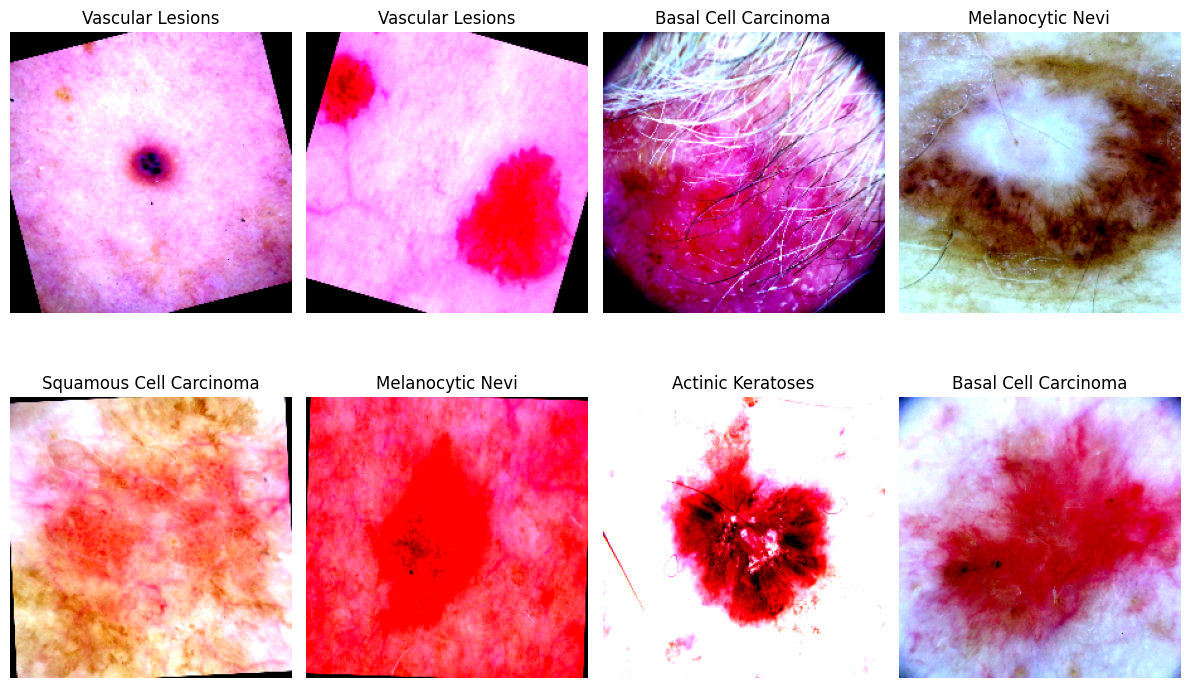

In [44]:
show_augmented_batch(train_loader, le)

In [45]:
model = timm.create_model('efficientnet_b3', pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(model.classifier.in_features, 8)
)
model = model.to('cuda')

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

In [46]:
classes = np.unique(labels)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)

# Convert to tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class weights:", class_weights_tensor)

Class weights: tensor([1.0812, 0.9010, 1.0301, 1.0812, 0.9010, 0.9010, 1.0812, 1.0812],
       device='cuda:0')


In [47]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [48]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [49]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return running_loss / total, correct / total

In [50]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
lrs = []

EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    scheduler.step(val_loss)

    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    lrs.append(get_lr(optimizer))

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
    print(f"  LR: {lrs[-1]:.6f}")

Epoch 1/10
  Train Loss: 0.9626, Accuracy: 0.6539
  Val   Loss: 0.6676, Accuracy: 0.7993
  LR: 0.000100
Epoch 2/10
  Train Loss: 0.3784, Accuracy: 0.8663
  Val   Loss: 0.4001, Accuracy: 0.8486
  LR: 0.000100
Epoch 3/10
  Train Loss: 0.2400, Accuracy: 0.9128
  Val   Loss: 0.3603, Accuracy: 0.8652
  LR: 0.000100
Epoch 4/10
  Train Loss: 0.1622, Accuracy: 0.9425
  Val   Loss: 0.3425, Accuracy: 0.8782
  LR: 0.000100
Epoch 5/10
  Train Loss: 0.1255, Accuracy: 0.9550
  Val   Loss: 0.3641, Accuracy: 0.8745
  LR: 0.000100
Epoch 6/10
  Train Loss: 0.0936, Accuracy: 0.9684
  Val   Loss: 0.3495, Accuracy: 0.8886
  LR: 0.000100
Epoch 7/10
  Train Loss: 0.0687, Accuracy: 0.9758
  Val   Loss: 0.3557, Accuracy: 0.8902
  LR: 0.000100
Epoch 8/10
  Train Loss: 0.0615, Accuracy: 0.9783
  Val   Loss: 0.3729, Accuracy: 0.8941
  LR: 0.000050
Epoch 9/10
  Train Loss: 0.0376, Accuracy: 0.9880
  Val   Loss: 0.3462, Accuracy: 0.8997
  LR: 0.000050
Epoch 10/10
  Train Loss: 0.0268, Accuracy: 0.9906
  Val   Loss:

In [51]:
torch.save(model.state_dict(), "model_weights.pth")

In [52]:
torch.save(model, "full_model.pth")

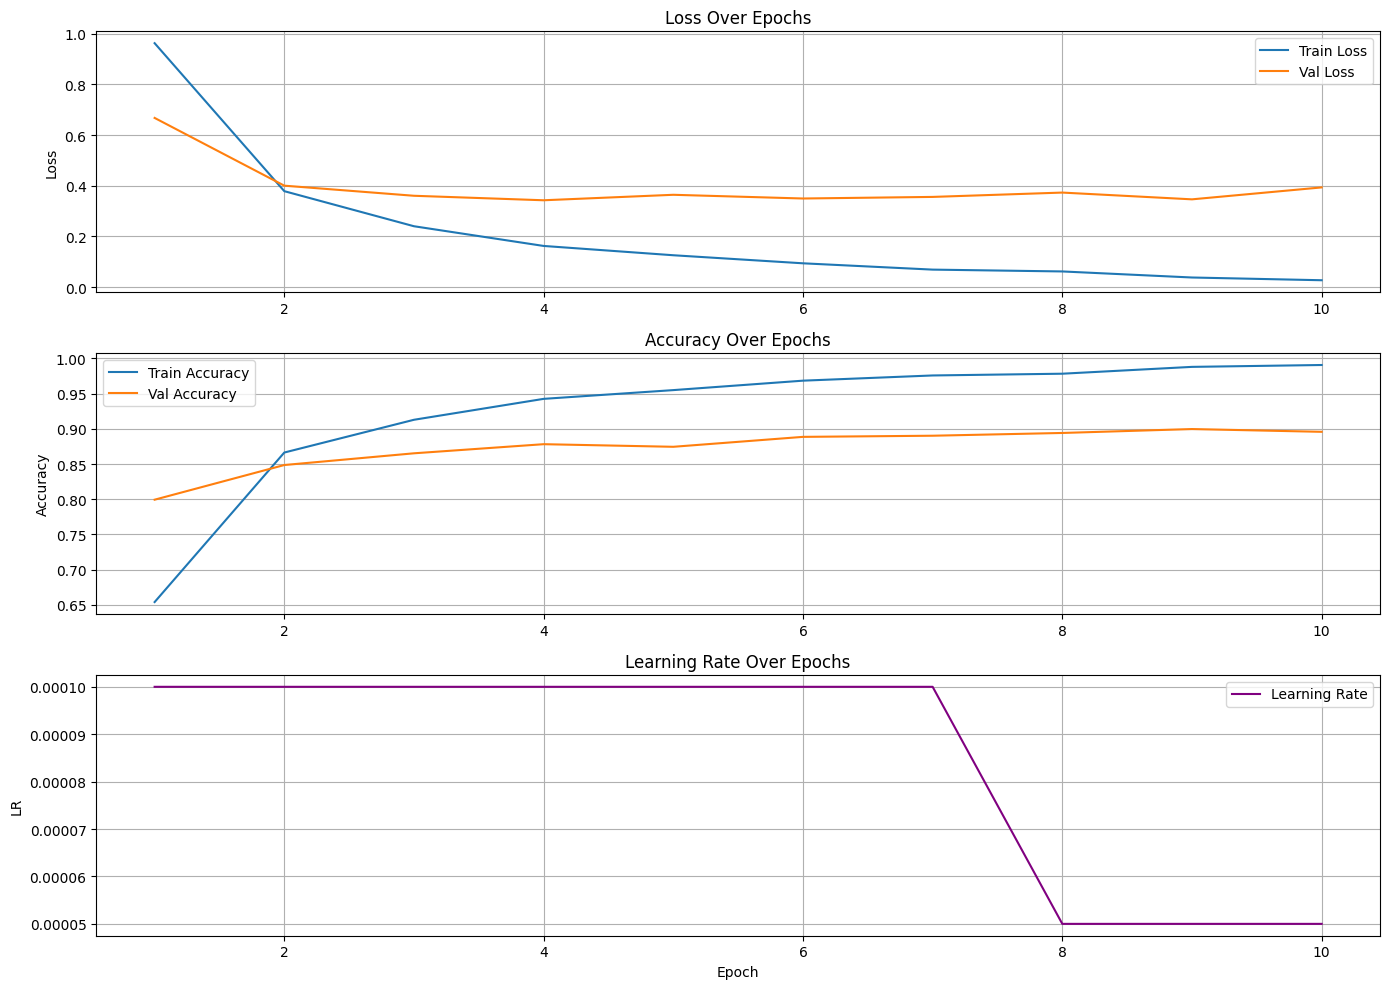

In [53]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(14, 10))

# Loss
plt.subplot(3, 1, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(3, 1, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)

# Learning Rate
plt.subplot(3, 1, 3)
plt.plot(epochs, lrs, label='Learning Rate', color='purple')
plt.xlabel('Epoch')
plt.ylabel('LR')
plt.title('Learning Rate Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

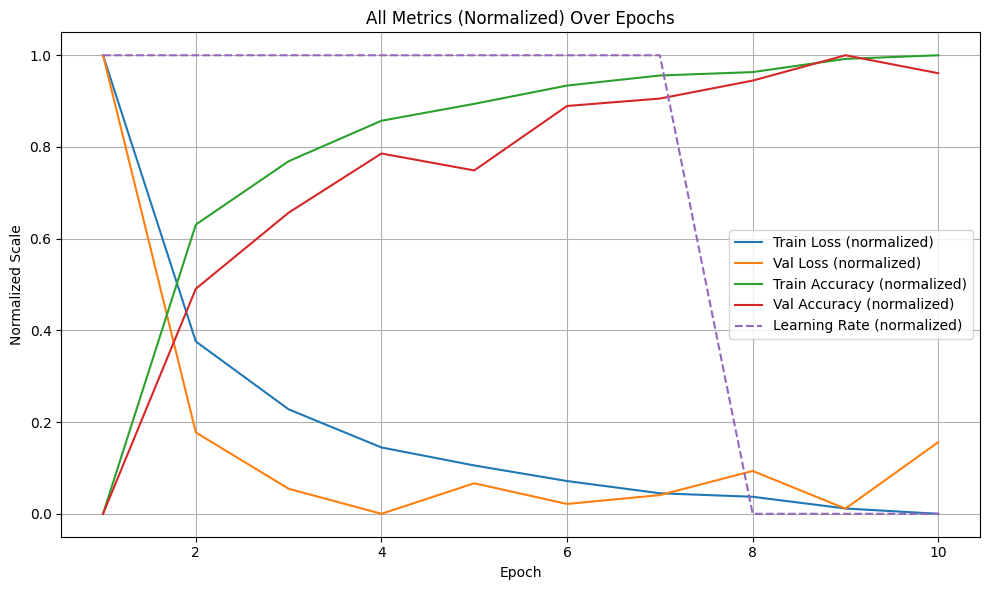

In [54]:
def normalize(values):
    return (np.array(values) - np.min(values)) / (np.max(values) - np.min(values))

plt.figure(figsize=(10, 6))
plt.plot(epochs, normalize(train_losses), label='Train Loss (normalized)')
plt.plot(epochs, normalize(val_losses), label='Val Loss (normalized)')
plt.plot(epochs, normalize(train_accuracies), label='Train Accuracy (normalized)')
plt.plot(epochs, normalize(val_accuracies), label='Val Accuracy (normalized)')
plt.plot(epochs, normalize(lrs), label='Learning Rate (normalized)', linestyle='--')

plt.title('All Metrics (Normalized) Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Normalized Scale')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()